In [362]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Bidirectional, GRU, LSTM, Dense
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten
from keras.models import Model
from sklearn.metrics import mean_squared_error
import yfinance as yf
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error
#
Stock_symbol = 'TCEHY'
#

end_date =  date.today().strftime("%Y-%m-%d")
df = yf.download(Stock_symbol, start='2013-01-01', end = '2022-12-31')
#df = pd.read_csv("APPLE.csv")
#
parameter = 'Close'
#


[*********************100%***********************]  1 of 1 completed


In [363]:

train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[parameter]


#data_filtered.tail()
data_filtered.isna().sum().sum()
data_filtered.head()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume
Date,,,,,
2013-01-02 00:00:00-05:00,6.730,6.672,6.674,6.720,362500
2013-01-03 00:00:00-05:00,6.734,6.660,6.734,6.660,355000
2013-01-04 00:00:00-05:00,6.742,6.652,6.658,6.694,101000
2013-01-07 00:00:00-05:00,6.600,6.556,6.590,6.600,83000
2013-01-08 00:00:00-05:00,6.592,6.540,6.592,6.570,49000


In [364]:
from sklearn.preprocessing import MinMaxScaler
# Get the number of rows in the data
nrows = data_filtered.shape[0]
print(nrows)
# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
#print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)
data_filtered.head()

2518


,High,Low,Open,Close,Volume
Date,,,,,
2013-01-02 00:00:00-05:00,6.730,6.672,6.674,6.720,362500
2013-01-03 00:00:00-05:00,6.734,6.660,6.734,6.660,355000
2013-01-04 00:00:00-05:00,6.742,6.652,6.658,6.694,101000
2013-01-07 00:00:00-05:00,6.600,6.556,6.590,6.600,83000
2013-01-08 00:00:00-05:00,6.592,6.540,6.592,6.570,49000


In [365]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
prediction = "Close"
index_Close = data.columns.get_loc(prediction)

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

#Future prediction
n=7
#

def partition_dataset_n(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len-n):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i+n-1, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
X_train, Y_train = partition_dataset(sequence_length, train_data)
X_test, Y_test = partition_dataset(sequence_length, test_data)

X_train_n, Y_train_n = partition_dataset_n(sequence_length, train_data)
X_test_n, Y_test_n = partition_dataset_n(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_train_n.shape, Y_train_n.shape)
print(X_test_n.shape, Y_test_n.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(X_train[1][sequence_length-1][index_Close])
print(Y_train[0])
print(X_train_n[n][sequence_length-1][index_Close])
print(Y_train_n[0])

(1965, 50, 5) (1965,)
(503, 50, 5) (503,)
(1958, 50, 5) (1958,)
(496, 50, 5) (496,)
0.010257402860333928
0.010257402860333928
2.1507557668609678e-05
2.1507557668609678e-05


In [380]:
def LSTM_1():
    Lstm_1 = Sequential()
    Lstm_1.add(LSTM(64, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
    Lstm_1.add(LSTM(64))
    Lstm_1.add(Dense(1, activation = 'ReLU'))
    Lstm_1.compile(loss = 'mean_squared_error', optimizer = 'Adam', metrics = ['mae'])
    return Lstm_1

In [381]:
def LSTM_2():
    Lstm_2 = Sequential()
    Lstm_2.add(LSTM(64, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
    Lstm_2.add(LSTM(64, return_sequences = True))
    Lstm_2.add(LSTM(64))
    Lstm_2.add(Dense(1, activation = 'ReLU'))
    Lstm_2.compile(loss = 'mean_squared_error', optimizer = 'Adam', metrics = ['mae'])
    return Lstm_2

In [382]:
def Bi_1():
    Bi_1 = Sequential()
    Bi_1.add(Bidirectional(LSTM(64, return_sequences=True), input_shape = (X_train.shape[1],X_train.shape[2])))
    Bi_1.add(Bidirectional(LSTM(64)))
    Bi_1.add(Dense(1, activation = 'ReLU'))
    Bi_1.compile(loss = 'mean_squared_error', optimizer = 'Adam', metrics=['mae'])
    return Bi_1

In [383]:
def Bi_2():
    Bi_2 = Sequential()
    Bi_2.add(Bidirectional(LSTM(64, return_sequences=True), input_shape = (X_train.shape[1],X_train.shape[2])))
    Bi_2.add(Bidirectional(LSTM(64, return_sequences=True)))
    Bi_2.add(Bidirectional(LSTM(64)))
    Bi_2.add(Dense(1, activation = 'ReLU'))
    Bi_2.compile(loss = 'mean_squared_error', optimizer = 'Adam', metrics=['mae'])
    return Bi_2

In [384]:
def GRU_1():
    GRU_1 = Sequential()
    GRU_1.add(GRU(64, return_sequences=True, input_shape= (X_train.shape[1],X_train.shape[2])))
    GRU_1.add(GRU(64, return_sequences=False))
    GRU_1.add(Dense(1, activation='ReLU'))
    GRU_1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])
    return GRU_1

In [385]:
def GRU_2():
    GRU_2 = Sequential()
    GRU_2.add(GRU(64, return_sequences=True, input_shape= (X_train.shape[1],X_train.shape[2])))
    GRU_2.add(GRU(64, return_sequences=True))
    GRU_2.add(GRU(64, return_sequences=False))
    GRU_2.add(Dense(1, activation='ReLU'))
    GRU_2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])
    return GRU_2

In [386]:
def Bi_GRU_1():
    Bi_GRU_1 = Sequential()
    Bi_GRU_1.add(Bidirectional(GRU(64, return_sequences=True), input_shape = (X_train.shape[1],X_train.shape[2])))
    Bi_GRU_1.add(Bidirectional(GRU(64, return_sequences=False)))
    Bi_GRU_1.add(Dense(1, activation = 'ReLU'))
    Bi_GRU_1.compile(loss = 'mean_squared_error', optimizer = 'Adam', metrics=['mae'])
    return Bi_GRU_1

In [387]:
def Bi_GRU_2():
    Bi_GRU_2 = Sequential()
    Bi_GRU_2.add(Bidirectional(GRU(64, return_sequences=True), input_shape = (X_train.shape[1],X_train.shape[2])))
    Bi_GRU_2.add(Bidirectional(GRU(64, return_sequences=True)))
    Bi_GRU_2.add(Bidirectional(GRU(64)))
    Bi_GRU_2.add(Dense(1, activation = 'ReLU'))
    Bi_GRU_2.compile(loss = 'mean_squared_error', optimizer = 'Adam', metrics=['mae'])
    return Bi_GRU_2

In [388]:
def CNN_1():
    CNN_1 = Sequential()
    CNN_1.add(Conv1D(64, kernel_size=3, activation='relu', input_shape= (X_train.shape[1],X_train.shape[2])))
    CNN_1.add(MaxPooling1D(pool_size=2))
    CNN_1.add(Conv1D(64, kernel_size=3, activation='relu'))
    CNN_1.add(MaxPooling1D(pool_size=2))
    CNN_1.add(Flatten())
    CNN_1.add(Dense(1, activation='ReLU'))
    CNN_1.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])
    return CNN_1

In [389]:
def CNN_2():
    CNN_2 = Sequential()
    CNN_2.add(Conv1D(64, kernel_size=3, activation='relu', input_shape= (X_train.shape[1],X_train.shape[2])))
    CNN_2.add(MaxPooling1D(pool_size=2))
    CNN_2.add(Conv1D(64, kernel_size=3, activation='relu'))
    CNN_2.add(MaxPooling1D(pool_size=2))
    CNN_2.add(Conv1D(64, kernel_size=3, activation='relu'))
    CNN_2.add(MaxPooling1D(pool_size=2))
    CNN_2.add(Flatten())
    CNN_2.add(Dense(1, activation='ReLU'))
    CNN_2.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])
    return CNN_2

In [390]:
print("Choose The Symbol to Impliment the desire Model: ")
print("LSTM 2 Layer - A")
print("LSTM 3 Layer - B")
print("Bidirectional LSTM 2 Layer- C")
print("Bidirectional LSTM 3 Layer - D")
print("GRU 2 Layer - E")
print("GRU 3 Layer - F")
print("Bidirectional GRU 2 Layer- G")
print("Bidirectional GRU 3 Layer- H")
print("CNN 2 Layer - I")
print("CNN 3 Layer - J")

Choose The Symbol to Impliment the desire Model: 
LSTM 2 Layer - A
LSTM 3 Layer - B
Bidirectional LSTM 2 Layer- C
Bidirectional LSTM 3 Layer - D
GRU 2 Layer - E
GRU 3 Layer - F
Bidirectional GRU 2 Layer- G
Bidirectional GRU 3 Layer- H
CNN 2 Layer - I
CNN 3 Layer - J


In [580]:
MODEL = input('Enter the symbol of the desired MODEL: ').upper()

Enter the symbol of the desired MODEL: j


In [581]:
if MODEL == 'A':
    model = LSTM_1()
    print('LSTM 2 Layer')
elif MODEL == 'B':
    model = LSTM_2()
    print('LSTM 3 Layer')
elif MODEL == 'C':    
    model = Bi_1()
    print('BI-LSTM 2 Layer')
elif MODEL == 'D':    
    model = Bi_2()
    print('BI-LSTM 3 Layer')
elif MODEL == 'E':    
    model = GRU_1()
    print('GRU 2 Layer')
elif MODEL == 'F':
    model = GRU_2()
    print('GRU 3 Layer')
elif MODEL == 'G':
    model = Bi_GRU_1()
    print('Bi-GRU 2 Layer')
elif MODEL == 'H':
    model = Bi_GRU_2()
    print('Bi-GRU 3 Layer')
elif MODEL == 'I':    
    model = CNN_1()
    print('CNN 2 Layer')
elif MODEL == 'J':
    model = CNN_2()
    print('CNN 3 Layer')
else:
    print('MODEL code is invalid or MODEL is not included in the system.')


CNN 3 Layer


# One Step Ahead

In [ ]:
sf = [2, 5, 6, 7, 8, 10, 14, 16, 17, 20]
num_train = np.size(X_train, 0)
num_valid = np.size(X_test, 0)
print(X_train.shape)
X_train   = X_train[:,:,sf]
print(X_train.shape)
Y_train   = Y_train.reshape(num_train)  # Solve bug
X_test   = X_test[:,:,sf]
Y_test   = Y_test.reshape(num_valid) 

In [582]:
model.fit(X_train, Y_train, epochs = 25, batch_size = 32, verbose = 1)

Epoch 1/25
62/62 [==============================] - 1s 8ms/step - loss: 0.0046 - mae: 0.0411
Epoch 2/25
62/62 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0235
Epoch 3/25
62/62 [==============================] - 1s 10ms/step - loss: 9.6065e-04 - mae: 0.0222
Epoch 4/25
62/62 [==============================] - 1s 10ms/step - loss: 7.8365e-04 - mae: 0.0200
Epoch 5/25
62/62 [==============================] - 0s 7ms/step - loss: 7.9452e-04 - mae: 0.0199
Epoch 6/25
62/62 [==============================] - 0s 7ms/step - loss: 6.8845e-04 - mae: 0.0185
Epoch 7/25
62/62 [==============================] - 1s 10ms/step - loss: 6.2699e-04 - mae: 0.0178
Epoch 8/25
62/62 [==============================] - 1s 8ms/step - loss: 5.3061e-04 - mae: 0.0163
Epoch 9/25
62/62 [==============================] - 0s 7ms/step - loss: 4.9042e-04 - mae: 0.0154
Epoch 10/25
62/62 [==============================] - 0s 7ms/step - loss: 4.7744e-04 - mae: 0.0154
Epoch 11/25
62/62 [===============

In [583]:
test_predict_1 = model.predict(X_test)

16/16 [==============================] - 0s 3ms/step


In [584]:
from sklearn.metrics import r2_score
accuracy_1 = r2_score(Y_test, test_predict_1)
print('Accuracy:', accuracy_1)

Accuracy: 0.9063987514007253


In [585]:
mae_1 = mean_absolute_error(Y_test, test_predict_1)
print("Mean Absolute Error:", mae_1)

Mean Absolute Error: 0.04629547886741838


In [586]:
mse_1 = mean_squared_error(Y_test ,test_predict_1)
rmse_1 = np.sqrt(mse_1)
print('MSE:', mse_1)
print('RMSE:', rmse_1)

MSE: 0.0032796778516073835
RMSE: 0.05726847170658026


In [587]:
y_pred_scaled = test_predict_1
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(Y_test.reshape(-1, 1))

In [588]:
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

Mean Absolute Percentage Error (MAPE): 7.95 %


In [589]:
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Percentage Error (MDAPE): 6.61 %


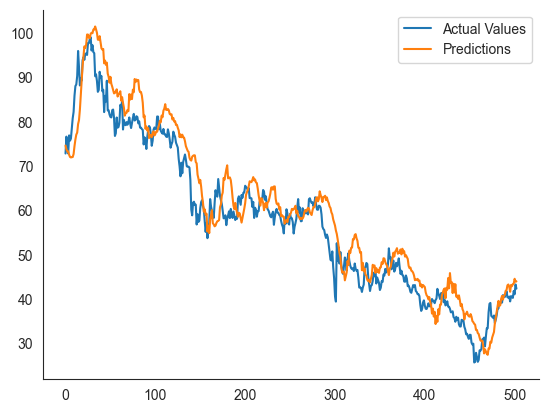

In [590]:
#plt.title("LSTM 2 Layers for 1 Step Ahead")
plt.plot(y_test_unscaled, label='Actual Values')
plt.plot(y_pred, label='Predictions')
plt.legend()
plt.show()

In [591]:
# # The date from which on the date is displayed
# display_start_date = "2021-01-01" 

# # Add the difference between the valid and predicted prices
# train = pd.DataFrame(data_filtered_ext[parameter][:train_data_len + 1]).rename(columns={parameter: 'Y_train'})
# valid = pd.DataFrame(data_filtered_ext[parameter][train_data_len:]).rename(columns={parameter: 'Y_test'})
# valid.insert(1, "y_pred", y_pred, True)
# valid.insert(1, "residuals", valid["y_pred"] - valid["Y_test"], True)
# df_union = pd.concat([train, valid])

# # Zoom in to a closer timeframe
# df_union_zoom = df_union[df_union.index > display_start_date]

# # Create the lineplot
# fig, ax1 = plt.subplots(figsize=(16, 8))
# plt.title("y_pred vs Y_test")
# plt.ylabel(Stock_symbol, fontsize=18)
# sns.set_palette(["#090364", "#1960EF", "#EF5919"])
# sns.lineplot(data=df_union_zoom[['y_pred', 'Y_train', 'Y_test']], linewidth=1.0, dashes=False, ax=ax1)

# # Create the bar plot with the differences
# df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
# ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
# plt.legend()
# plt.show()

# Nth Step Ahead

In [592]:
model.fit(X_train_n,Y_train_n, epochs = 25, batch_size = 32, verbose = 1)

Epoch 1/25
62/62 [==============================] - 0s 8ms/step - loss: 5.6366e-04 - mae: 0.0165
Epoch 2/25
62/62 [==============================] - 1s 10ms/step - loss: 5.4822e-04 - mae: 0.0166
Epoch 3/25
62/62 [==============================] - 1s 11ms/step - loss: 7.4798e-04 - mae: 0.0193
Epoch 4/25
62/62 [==============================] - 1s 10ms/step - loss: 5.1982e-04 - mae: 0.0161
Epoch 5/25
62/62 [==============================] - 0s 6ms/step - loss: 4.9522e-04 - mae: 0.0158
Epoch 6/25
62/62 [==============================] - 0s 7ms/step - loss: 4.9043e-04 - mae: 0.0159
Epoch 7/25
62/62 [==============================] - 1s 9ms/step - loss: 4.8097e-04 - mae: 0.0154
Epoch 8/25
62/62 [==============================] - 1s 10ms/step - loss: 4.9479e-04 - mae: 0.0157
Epoch 9/25
62/62 [==============================] - 1s 9ms/step - loss: 5.1786e-04 - mae: 0.0160
Epoch 10/25
62/62 [==============================] - 1s 11ms/step - loss: 5.2292e-04 - mae: 0.0164
Epoch 11/25
62/62 [=====

In [593]:
test_predict_n = model.predict(X_test_n)

16/16 [==============================] - 0s 3ms/step


In [594]:
accuracy_2 = r2_score(Y_test_n, test_predict_n)
print('Accuracy_2:', accuracy_2)

Accuracy_2: 0.8583622378366913


In [595]:
mae_2 = mean_absolute_error(Y_test_n, test_predict_n)
print("Mean Absolute Error:", mae_2)

Mean Absolute Error: 0.0524402568286771


In [596]:
mse_2 = mean_squared_error(Y_test_n ,test_predict_n)
rmse_2 = np.sqrt(mse_2)
print('MSE:', mse_2)
print('RMSE:', rmse_2)

MSE: 0.004967479917970539
RMSE: 0.07048035129006197


In [597]:
y_pred_scaled_n = test_predict_n
y_pred_n = scaler_pred.inverse_transform(y_pred_scaled_n)
y_test_unscaled_n = scaler_pred.inverse_transform(Y_test_n.reshape(-1, 1))

In [598]:
MAPE_2 = np.mean((np.abs(np.subtract(y_test_unscaled_n, y_pred_n)/ y_test_unscaled_n))) * 100
print(f'Mean Absolute Percentage Error (MAPE_2): {np.round(MAPE_2, 2)} %')

Mean Absolute Percentage Error (MAPE_2): 8.93 %


In [599]:
MDAPE_2 = np.median((np.abs(np.subtract(y_test_unscaled_n, y_pred_n)/ y_test_unscaled_n)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE_2): {np.round(MDAPE_2, 2)} %')

Median Absolute Percentage Error (MDAPE_2): 7.0 %


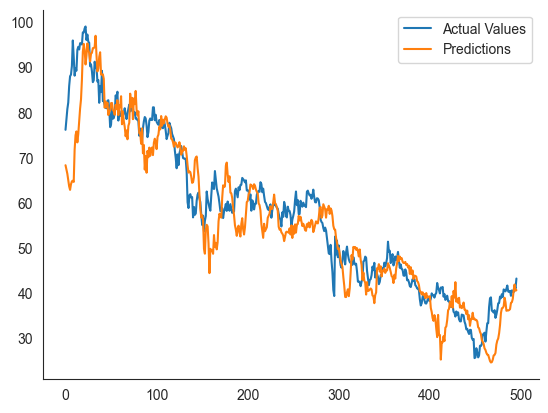

In [600]:
plt.plot(y_test_unscaled_n, label='Actual Values')
plt.plot(y_pred_n, label='Predictions')
#plt.title("LSTM 2 Layers for 7 Step Ahead")
plt.legend()
plt.show()

In [484]:
# # The date from which on the date is displayed
# display_start_date = "2021-01-01" 

# # Add the difference between the valid and predicted prices
# train = pd.DataFrame(data_filtered_ext[parameter][:train_data_len + 1]).rename(columns={parameter: 'Y_train_n'})
# valid = pd.DataFrame(data_filtered_ext[parameter][train_data_len:-n]).rename(columns={parameter: 'Y_test_n'})
# valid.insert(1, "y_pred_n", y_pred_n, True)
# valid.insert(1, "residuals", valid["y_pred_n"] - valid["Y_test_n"], True)
# df_union = pd.concat([train, valid])

# # Zoom in to a closer timeframe
# df_union_zoom = df_union[df_union.index > display_start_date]

# # Create the lineplot
# fig, ax1 = plt.subplots(figsize=(16, 8))
# plt.title("y_pred vs Y_test")
# plt.ylabel(Stock_symbol, fontsize=18)
# sns.set_palette(["#090364", "#1960EF", "#EF5919"])
# sns.lineplot(data=df_union_zoom[['y_pred_n', 'Y_train_n', 'Y_test_n']], linewidth=1.0, dashes=False, ax=ax1)

# # Create the bar plot with the differences
# df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
# ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
# plt.legend()
# plt.show()

In [100]:

# df_temp = df[-sequence_length:]
# new_df = df_temp.filter(FEATURES)

# N = sequence_length

# # Get the last N day closing price values and scale the data to be values between 0 and 1
# last_N_days = new_df[-sequence_length:].values
# last_N_days_scaled = scaler.transform(last_N_days)

# # Create an empty list and Append past N days
# X_test_new = []
# X_test_new.append(last_N_days_scaled)

# # Convert the X_test data set to a numpy array and reshape the data
# pred_price_scaled = model.predict(np.array(X_test_new))
# pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# # Print last price and predicted price for the next day
# price_today = np.round(new_df[parameter][-1], 2)
# predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
# change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

# plus = '+'; minus = ''
# print(f'The {parameter} price for {Stock_symbol} at {end_date} was {price_today}')
# print(f'The predicted {parameter} price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')
